<a href="https://colab.research.google.com/github/river6907/Bigdata-Analysis/blob/main/%EC%8B%A4%EC%8A%B513_Regression_%EA%B0%95%EB%8F%99%EC%A4%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **자동차 연비 예측하기: 회귀**

In [1]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.9.2


## 데이터 구하기

In [2]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

30286/30286 [==============================] - 0s 0us/step


'/root/.keras/datasets/auto-mpg.data'

In [3]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## 데이터 정제하기

In [4]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

**누락된 행을 삭제**

In [5]:
dataset = dataset.dropna()

"Origin" 열은 수치형이 아니고 범주형이므로 원-핫 인코딩(one-hot encoding)으로 변환

In [6]:
origin = dataset.pop('Origin')

In [7]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


## 데이터셋을 훈련 세트와 테스트 세트로 분할

In [8]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

## 데이터 조사

훈련 세트에서 몇 개의 열을 선택해 산점도 행렬 생성

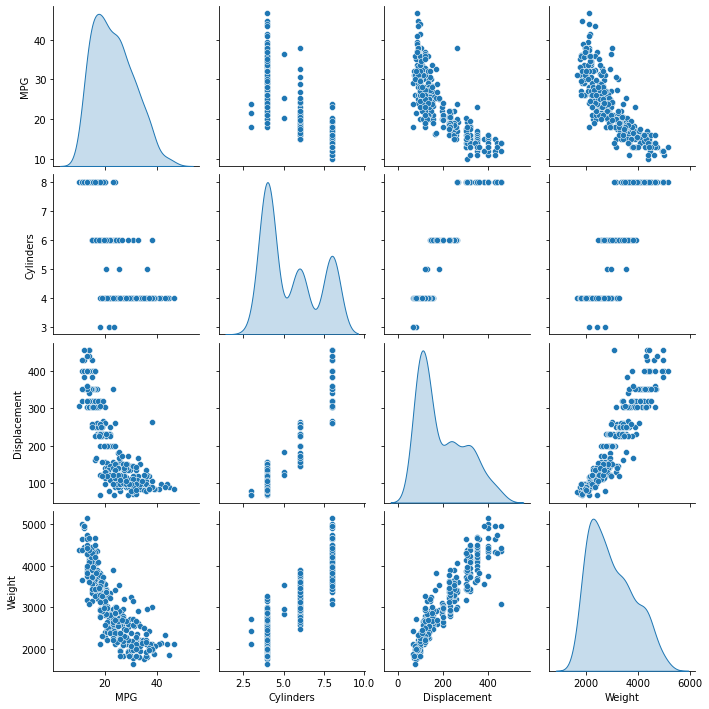

In [9]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

전반적인 통계 확인

In [10]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


## 특성과 레이블 분리

In [11]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

## 데이터 정규화

In [12]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

## 모델 만들기

In [13]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [14]:
model = build_model()

모델 확인

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


모델을 한번 실행 / 10 samples

In [16]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

1/1 [==============================] - 0s 319ms/step


array([[-0.43861562],
       [-0.39764673],
       [-0.16618952],
       [-0.40101722],
       [-0.22869718],
       [-0.09379898],
       [-0.3330774 ],
       [-0.2855202 ],
       [-0.13525125],
       [-0.19231908]], dtype=float32)

**모델 훈련**

In [17]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('-', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------

history 객체에 저장된 통계치를 사용해 모델의 훈련 과정 시각화

In [18]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.857550,0.988824,2.857550,7.786627,2.102481,7.786627,995
996,2.944187,1.047904,2.944187,7.927936,2.102904,7.927936,996
997,2.907557,1.020588,2.907557,7.658324,2.130461,7.658324,997
998,2.881619,1.004617,2.881619,7.987566,2.095869,7.987566,998
999,2.970717,1.012492,2.970717,7.998235,2.109882,7.998235,999


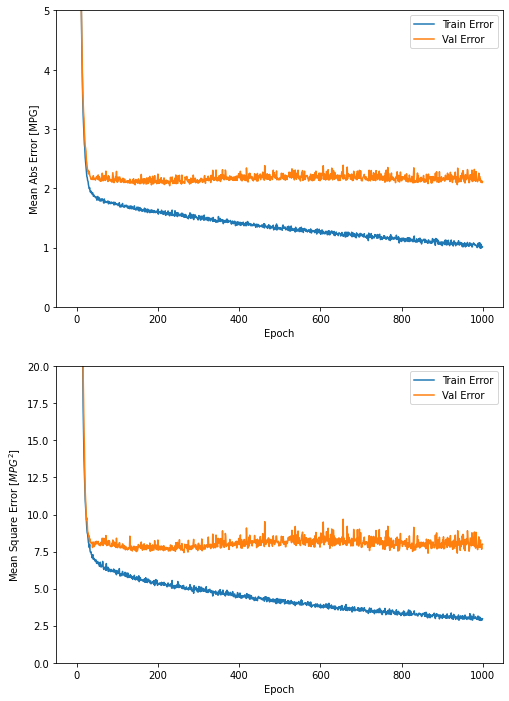

In [19]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history)

model.fit 메서드를 수정하여 검증 점수가 향상되지 않으면 자동으로 훈련을 멈추도록 한다.

* 에포크마다 훈련 상태를 점검하기 위해 EarlyStopping 콜백(callback)을 사용
* 지정된 에포크 횟수 동안 성능 향상이 없으면 자동으로 훈련이 멈춤


----------------------------------------------------------------------------------

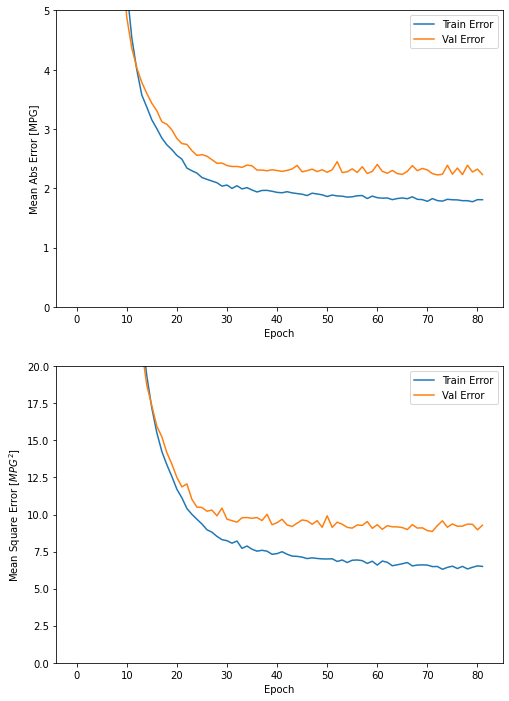

In [20]:
model = build_model()

# patience 매개변수는 성능 향상을 체크할 에포크 횟수
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

**테스트 세트에서 모델의 성능을 확인**

In [21]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("테스트 세트의 평균 절대 오차: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 6.2288 - mae: 1.9625 - mse: 6.2288 - 21ms/epoch - 7ms/step
테스트 세트의 평균 절대 오차:  1.96 MPG


## 예측

**테스트 세트에 있는 샘플을 사용해 MPG 값 예측**

3/3 [==============================] - 0s 3ms/step


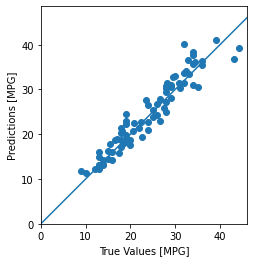

In [22]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

오차의 분포를 살펴 보기

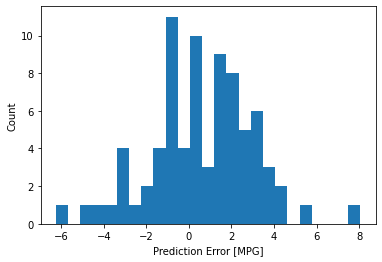

In [23]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

## 결론



* 평균 제곱 오차(MSE)는 회귀 문제에서 자주 사용하는 손실 함수이다.(분류 문제에서 사용하는 손실 함수와 다릅니다).
* 비슷하게 회귀에서 사용되는 평가 지표도 분류와 다르다. 많이 사용하는 회귀 지표는 평균 절댓값 오차(MAE)다.
* 수치 입력 데이터의 특성이 여러 가지 범위를 가질 때 동일한 범위가 되도록 각 특성의 스케일을 독립적으로 조정해야한다.
* 훈련 데이터가 많지 않다면 과대적합을 피하기 위해 은닉층의 개수가 적은 소규모 네트워크를 선택하는 방법이 좋다.
* 조기 종료(Early stopping)은 과대적합을 방지하기 위한 좋은 방법이다.